# 21-14. 프로젝트: 한국어 데이터로 챗봇 만들기

## Step 1. 데이터 수집하기

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.callbacks import EarlyStopping

In [2]:
row_file = pd.read_csv('/home/aiffel0042/aiffel/songys_chatbot/ChatbotData .csv')

In [3]:
row_file.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [4]:
row_file[row_file['label']==0]

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
5285,힘내야지,응원합니다!,0
5286,힘든 것 좀 끝났으면,다 지나갈 거예요.,0
5287,힘든 시기가 지나갔으면,다 지나갈 거예요.,0
5288,힘든 데도 날 도와준 사람,잊지말고 보답하세요.,0


In [5]:
row_file[row_file['label']!=0]

,Q,A,label
5290,1000일 만난 여자친구와 이별,더 오래 만날 사람 만날 거예요.,1
5291,10년 연애. 헤어졌습니다.,더 공허함이 크시겠네요.,1
5292,10년 연애사 되돌아보니 다 부질없네,더 좋은 사람 만나실 거예요.,1
5293,10년 연예의끝,더 마음이 허하겠어요.,1
5294,10년만나다 헤어지네,충분히 슬퍼하고 충분히 아파하다가 이겨내세요.,1
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


## Step 2. 데이터 전처리하기
영어 데이터와는 전혀 다른 데이터인만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.

In [6]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

  # (한글, 숫자, 영어 ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^ㄱ-ㅎ|가-힣|a-z|A-Z|0-9|?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [7]:
row_file['Q']

0                         12시 땡!
1                    1지망 학교 떨어졌어
2                   3박4일 놀러가고 싶다
3                3박4일 정도 놀러가고 싶다
4                        PPL 심하네
                  ...           
11818             훔쳐보는 것도 눈치 보임.
11819             훔쳐보는 것도 눈치 보임.
11820                흑기사 해주는 짝남.
11821    힘든 연애 좋은 연애라는게 무슨 차이일까?
11822                 힘들어서 결혼할까봐
Name: Q, Length: 11823, dtype: object

In [8]:
questions = []
for i in row_file['Q']:
    questions.append(preprocess_sentence(i))

answers = []
for i in row_file['A']:
    answers.append(preprocess_sentence(i))

In [9]:
questions

['12시 땡 !',
 '1지망 학교 떨어졌어',
 '3박4일 놀러가고 싶다',
 '3박4일 정도 놀러가고 싶다',
 'ppl 심하네',
 'sd카드 망가졌어',
 'sd카드 안돼',
 'sns 맞팔 왜 안하지',
 'sns 시간낭비인 거 아는데 매일 하는 중',
 'sns 시간낭비인데 자꾸 보게됨',
 'sns보면 나만 빼고 다 행복해보여',
 '가끔 궁금해',
 '가끔 뭐하는지 궁금해',
 '가끔은 혼자인게 좋다',
 '가난한 자의 설움',
 '가만 있어도 땀난다',
 '가상화폐 쫄딱 망함',
 '가스불 켜고 나갔어',
 '가스불 켜놓고 나온거 같아',
 '가스비 너무 많이 나왔다 .',
 '가스비 비싼데 감기 걸리겠어',
 '가스비 장난 아님',
 '가장 확실한 건 뭘까 ?',
 '가족 여행 가기로 했어',
 '가족 여행 고고',
 '가족 여행 어디로 가지 ?',
 '가족 있어 ?',
 '가족관계 알려 줘',
 '가족끼리 여행간다 .',
 '가족들 보고 싶어',
 '가족들이랑 서먹해',
 '가족들이랑 서먹해졌어',
 '가족들이랑 어디 가지 ?',
 '가족들이랑 여행 갈거야',
 '가족여행 가야지',
 '가족이 누구야 ?',
 '가족이랑 여행 가려고',
 '가족한테 스트레스 풀었어',
 '가출할까 ?',
 '가출해도 갈 데가 없어',
 '간만에 떨리니까 좋더라',
 '간만에 쇼핑 중',
 '간만에 휴식 중',
 '간식 뭐 먹을까',
 '간식 추천',
 '간장치킨 시켜야지',
 '간접흡연 싫어',
 '갈까 말까 고민 돼',
 '갈까 말까 ?',
 '감 말랭이 먹고 싶다 .',
 '감 말랭이 먹어야지',
 '감기 같애',
 '감기 걸린 것 같아',
 '감기 기운이 있어',
 '감기 들 거 같애',
 '감기가 오려나',
 '감기약이 없어',
 '감기인거 같애',
 '감미로운 목소리 좋아',
 '감정이 쓰레기통처럼 엉망진창이야',
 '감정컨트롤을 못하겠어',
 '감정컨트롤이 안돼',
 '감히 나를 무시하는 애가 있어',
 '갑자기 나쁜 생각이 막 들더라',
 '갑

In [10]:
answers

['하루가 또 가네요 .',
 '위로해 드립니다 .',
 '여행은 언제나 좋죠 .',
 '여행은 언제나 좋죠 .',
 '눈살이 찌푸려지죠 .',
 '다시 새로 사는 게 마음 편해요 .',
 '다시 새로 사는 게 마음 편해요 .',
 '잘 모르고 있을 수도 있어요 .',
 '시간을 정하고 해보세요 .',
 '시간을 정하고 해보세요 .',
 '자랑하는 자리니까요 .',
 '그 사람도 그럴 거예요 .',
 '그 사람도 그럴 거예요 .',
 '혼자를 즐기세요 .',
 '돈은 다시 들어올 거예요 .',
 '땀을 식혀주세요 .',
 '어서 잊고 새출발 하세요 .',
 '빨리 집에 돌아가서 끄고 나오세요 .',
 '빨리 집에 돌아가서 끄고 나오세요 .',
 '다음 달에는 더 절약해봐요 .',
 '따뜻하게 사세요 !',
 '다음 달에는 더 절약해봐요 .',
 '가장 확실한 시간은 오늘이에요 . 어제와 내일을 놓고 고민하느라 시간을 낭비하지 마세요 .',
 '온 가족이 모두 마음에 드는 곳으로 가보세요 .',
 '온 가족이 모두 마음에 드는 곳으로 가보세요 .',
 '온 가족이 모두 마음에 드는 곳으로 가보세요 .',
 '저를 만들어 준 사람을 부모님 , 저랑 이야기해 주는 사람을 친구로 생각하고 있어요',
 '저를 만들어 준 사람을 부모님 , 저랑 이야기해 주는 사람을 친구로 생각하고 있어요',
 '더 가까워질 기회가 되겠네요 .',
 '저도요 .',
 '다들 바빠서 이야기할 시간이 부족했나봐요 .',
 '다들 바빠서 이야기할 시간이 부족했나봐요 .',
 '온 가족이 모두 마음에 드는 곳으로 가보세요 .',
 '좋은 생각이에요 .',
 '더 가까워질 기회가 되겠네요 .',
 '저를 만들어 준 사람을 부모님 , 저랑 이야기해 주는 사람을 친구로 생각하고 있어요',
 '좋은 생각이에요 .',
 '정말 후회할 습관이에요 .',
 '무모한 결정을 내리지 마세요 .',
 '선생님이나 기관에 연락해보세요 .',
 '떨리는 감정은 그 자체로 소중해요 .',
 '득템했길 바라요 .',
 

## Step 3. SubwordTextEncoder 사용하기
한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야한다고 많은 분들이 알고있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.

In [11]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성.
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [12]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

슝=3


In [13]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8164]
END_TOKEN의 번호 : [8165]


In [14]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8166


In [15]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5758, 610, 2488, 4159]
정수 인코딩 후의 21번째 답변 샘플: [2355, 7504, 7, 6269, 97, 1]


In [16]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이.
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [17]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


In [18]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8166
필터링 후의 샘플 개수: 11823
필터링 후의 샘플 개수: 11823


In [19]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Step 4. 모델 구성하기
위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.

### 1. 모델 생성

1-1 포시셔널 인코딩 레이어

In [20]:
# 포지셔널 인코딩 레이어; 단어 위치 벡터 추가
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
print("슝=3")

슝=3


1-2 어텐션 레이어

In [21]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  """어텐션 가중치를 계산. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output
print("슝=3")

슝=3


In [22]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다.
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷-프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다.
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


1-3 마스킹 레이어

In [23]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


In [24]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


1-4 인코더

In [25]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

# 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝♥")

슝♥


In [26]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

# 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


1-5 디코더

In [27]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


In [28]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

# 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
# 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

# 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

# Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


1-6 트랜스포머

In [29]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

	# 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크하기위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


### 2. 모델 학습

2-1 모델 생성

In [30]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Model)                 (None, None, 256)    5253120     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

2-2 손실함수

In [31]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("슝=3")

슝=3


2-3 커스텀된 학습률(Learning rate)

In [32]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


2-4 모델 컴파일

In [33]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


2-5 모델 훈련

In [34]:
EPOCHS = 100
early_stop = EarlyStopping(monitor='accuracy', patience=3)
history = model.fit(dataset, epochs=EPOCHS, verbose=1, callbacks=early_stop)

Epoch 1/100
185/185 [==============================] - 19s 101ms/step - loss: 1.4436 - accuracy: 0.0218
Epoch 2/100
185/185 [==============================] - 19s 102ms/step - loss: 1.1905 - accuracy: 0.0432
Epoch 3/100
185/185 [==============================] - 19s 102ms/step - loss: 1.0306 - accuracy: 0.0499
Epoch 4/100
185/185 [==============================] - 19s 102ms/step - loss: 0.9598 - accuracy: 0.0519
Epoch 5/100
185/185 [==============================] - 19s 102ms/step - loss: 0.9191 - accuracy: 0.0541
Epoch 6/100
185/185 [==============================] - 19s 102ms/step - loss: 0.8845 - accuracy: 0.0560
Epoch 7/100
185/185 [==============================] - 19s 102ms/step - loss: 0.8508 - accuracy: 0.0575
Epoch 8/100
185/185 [==============================] - 19s 102ms/step - loss: 0.8140 - accuracy: 0.0596
Epoch 9/100
185/185 [==============================] - 19s 102ms/step - loss: 0.7746 - accuracy: 0.0620
Epoch 10/100
185/185 [==============================] - 19s 102m

185/185 [==============================] - 19s 102ms/step - loss: 0.0976 - accuracy: 0.1500
Epoch 80/100
185/185 [==============================] - 19s 102ms/step - loss: 0.0965 - accuracy: 0.1502
Epoch 81/100
185/185 [==============================] - 19s 102ms/step - loss: 0.0954 - accuracy: 0.1504
Epoch 82/100
185/185 [==============================] - 19s 102ms/step - loss: 0.0945 - accuracy: 0.1506
Epoch 83/100
185/185 [==============================] - 19s 103ms/step - loss: 0.0937 - accuracy: 0.1506
Epoch 84/100
185/185 [==============================] - 19s 101ms/step - loss: 0.0932 - accuracy: 0.1509s - loss: 0.0932 - accuracy: 0.
Epoch 85/100
185/185 [==============================] - 19s 100ms/step - loss: 0.0910 - accuracy: 0.1513
Epoch 86/100
185/185 [==============================] - 19s 102ms/step - loss: 0.0910 - accuracy: 0.1514s - loss: - E
Epoch 87/100
185/185 [==============================] - 19s 105ms/step - loss: 0.0892 - accuracy: 0.1517
Epoch 88/100
185/185 [==

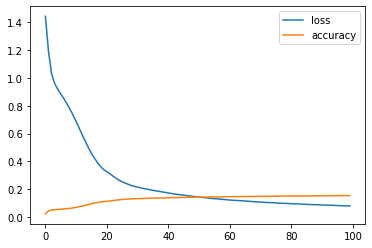

In [35]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.legend()
plt.show()

## Step 5. 모델 평가하기
Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.

In [36]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞 뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없으므로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [37]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


In [38]:
sentence_generation("너 어디있었어?")

입력 : 너 어디있었어?
출력 : 가게부를 써보세요 .


'가게부를 써보세요 .'

epoch 20; '저도 데려가세요 .'
epoch 100; '오늘 헤어졌어 라고 하면 위로해 드려요 .'

In [39]:
sentence_generation("넌 왜 이렇게 멍청해?")

입력 : 넌 왜 이렇게 멍청해?
출력 : 저는 생각보다 많이 벌어요 .


'저는 생각보다 많이 벌어요 .'

epoch 20; '그런 사람 만나길 바랄게요 .'
epoch 100; '저는 마음을 이어주는 위로봇입니다 .'

In [40]:
sentence_generation("세상은 참 넓어.")

입력 : 세상은 참 넓어.
출력 : 성공하길 바랍니다 .


'성공하길 바랍니다 .'

epoch 20; '서로 속도를 맞춰보세요 .'
epoch 100; '그 말을 한 사람이 가장 이상할 거예요 .'

In [41]:
sentence_generation("내 이름을 알아?")

입력 : 내 이름을 알아?
출력 : 두통약 드세요 .


'두통약 드세요 .'

epoch 20; '이별이 사람을 변덕스럽게 만들더라고요 .'
epoch 100; '재미있나봐요 .'

In [42]:
sentence_generation("나 심심해.")

입력 : 나 심심해.
출력 : 친구들과 잘 어울려보세요 .


'친구들과 잘 어울려보세요 .'

In [43]:
sentence_generation("나랑 친구할래?")

입력 : 나랑 친구할래?
출력 : 사소한 거라도 있을 거예요 .


'사소한 거라도 있을 거예요 .'

In [44]:
sentence_generation("너는 어디에 있어?")

입력 : 너는 어디에 있어?
출력 : 벌써 그러면 안돼요 .


'벌써 그러면 안돼요 .'

In [45]:
sentence_generation("별들이 참 예쁘다.")

입력 : 별들이 참 예쁘다.
출력 : 사람을 잊는다는 건 쉬운 일이 아니니까요 .


'사람을 잊는다는 건 쉬운 일이 아니니까요 .'

In [46]:
sentence_generation("사랑해.")

입력 : 사랑해.
출력 : 억지로라도 긍정적인 감정을 끌어올려보세요 .


'억지로라도 긍정적인 감정을 끌어올려보세요 .'

In [47]:
sentence_generation("외로워.")

입력 : 외로워.
출력 : 혼자가 아니에요 .


'혼자가 아니에요 .'

## Step 6. 총평

학습과 무관하게 답변은 질문의 종류에 따라 퀄리티가 변화했다. 이는 해당 데이터의 출처로 인해 데이터의 편향성이 발생한 것이 원인으로 보인다. 또한 하이퍼 파라미터와 무관하게 accuracy는 20점 미만을 맴돌았으며 이는 모델 학습 그래프를 고려할때 모델의 깊이가 얕아서 발생하는 문제로 보인다.